In [1]:
# !pip install tqdm

In [1]:

import pandas as pd
pd.set_option('display.max_rows',6)
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

In [2]:
# import requests
# import io
# f_url = 'https://www.dropbox.com/s/3xe3gccl8ahl27y/torch_dataset_all.csv?dl=1'
# resp = requests.get(f_url)
# df = pd.read_csv(io.StringIO(resp.content.decode('utf-8')), converters={'features':ast.literal_eval})


# df = pd.read_csv('data/torch_dataset_all.csv', converters={'features':ast.literal_eval})
df = pd.read_csv('data/pre_torch_dataset_enc_12m.csv', converters={'var_vec_0':ast.literal_eval, 'var_vec_1':ast.literal_eval})

In [3]:
var_enum_col_list = [f for f in df.columns if 'enum' in f]

df.var_id = df.var_id.apply(lambda x: x[:2]+'%05d'%int(x[2:]))
df[var_enum_col_list] = df[var_enum_col_list].applymap(lambda x: 'V%s'%x)
df = df.sort_values(by=['var_id']).reset_index(drop=True)

In [4]:
cols_reorder = ['var_id'] + var_enum_col_list + [f for f in df.columns if f not in (['var_id'] + var_enum_col_list)]
df = df[cols_reorder]

In [5]:
oh_var_enum = OneHotEncoder(sparse=False).fit_transform(df[var_enum_col_list])

df['var_enum_v'] = oh_var_enum.tolist()
df['var_features'] = df.apply(lambda x:x.var_enum_v + x.var_vec_0 + x.var_vec_1, axis=1)
df = df[['var_id','var_features','var_obs','var_target']]

In [6]:
df

,var_id,var_features,var_obs,var_target
0,id00000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,74
1,id00001,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,72
2,id00002,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,25
...,...,...,...,...
21670,id21670,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,1
21671,id21671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,1
21672,id21672,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,1


In [26]:
from copy import deepcopy
df_backup = deepcopy(df)

In [27]:
df = deepcopy(df_backup)

In [28]:
df = df[df.var_target<=60].reset_index()

In [30]:
df

,index,var_id,var_features,var_obs,var_target
0,2,id00002,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,25
1,3,id00003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,11
2,5,id00005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",1,5
...,...,...,...,...,...
18768,21670,id21670,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,1
18769,21671,id21671,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,1
18770,21672,id21672,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0,1


In [31]:
df_obs = df[df.var_obs == 1]

In [32]:
x_train, x_test, y_train, y_test = train_test_split(df_obs.var_features,df_obs.var_target,random_state=0)

x_train, x_test = np.array(x_train.values.tolist()), np.array(x_test.values.tolist())
y_train, y_test = np.array(y_train.values.tolist()), np.array(y_test.values.tolist())

In [33]:
class ZNormalizer:
    eps = 1e-8
    def fit(self,x):
        self.mean = x.mean(0)
        self.std = x.std(0)
    def transform(self,x):
        return (x-self.mean)/(self.std+self.eps)

In [34]:
zn = ZNormalizer()
zn.fit(x_train)
x_train, x_test = zn.transform(x_train), zn.transform(x_test)

In [35]:
x_train, x_test = torch.tensor(x_train).float(), torch.tensor(x_test).float()
y_train, y_test = torch.tensor(y_train).float(), torch.tensor(y_test).float()

In [36]:
N_input_dim = x_train.shape[1]
N_input_dim

5103

In [37]:
class MixupAug(Dataset):
    
    def __init__(self, x_data, y_data, alpha):
        self.x_data = x_data
        self.y_data = y_data
        self.alpha = alpha
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, i):
        x,y = self.x_data[i], self.y_data[i]
        if self.alpha != 0:
            idx = random.randint(0,len(self.x_data)-1)
            x2 = self.x_data[idx]
            y2 = self.y_data[idx]
            lam = np.random.beta(self.alpha,self.alpha)
            x = lam*x + (1. - lam)*x2
            y = lam*y + (1. - lam)*y2
            
        return x,y
        
        
train_ds = MixupAug(x_train, y_train, 0.4)
x_train.is_cuda

False

In [38]:
class AAreg(nn.Module):
    def __init__(self,N_input_dim):
        super().__init__()
        
        size = 32
        depth = 1
        size1 = size // 2
        size2 = size1 // 2
        self.layer1 = nn.Linear(N_input_dim, size1)
        self.layer2 = nn.ModuleList([nn.Linear(size1,size2) for _ in range(depth)])
        self.layer3 = nn.Linear(size2,1)
        self.dropout = nn.Dropout2d(p=0.5)
        
    def forward(self,x):
        x = self.dropout(torch.relu(self.layer1(x)))
        for l in self.layer2:
            x = self.dropout(torch.relu(l(x)))
        x = self.layer3(x)
        x = x.squeeze(1)
        return x

In [39]:
model = AAreg(N_input_dim)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss = nn.MSELoss()

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)

loss_train_list, loss_test_list = [], []

epochs = 500
k = 10

for epoch in tqdm_notebook(range(epochs+1),desc='Training'):
    model.train()
    
    for _, (x_batch_train, y_batch_train) in enumerate(train_dl):
        x_batch_train = x_batch_train.cuda()
        y_batch_train = y_batch_train.cuda()

        y_hat_batch_train = model(x_batch_train)
        loss_train = loss(y_batch_train,y_hat_batch_train)
        
        break
#     x_train = x_train.cuda()
#     y_train = y_train.cuda()
#     y_hat_train = model(x_train)
#     loss_train = loss(y_train,y_hat_train)

    if epoch % k == 0:
        with torch.no_grad():
            model.eval()
            
            x_test = x_test.cuda()
            y_test = y_test.cuda()
            y_hat_test = model(x_test)
            loss_test = loss(y_test,y_hat_test)
        
        loss_train_list.append(loss_train.data.cpu().numpy())
        loss_test_list.append(loss_test.data.cpu().numpy())
        
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()
    
#     break
    

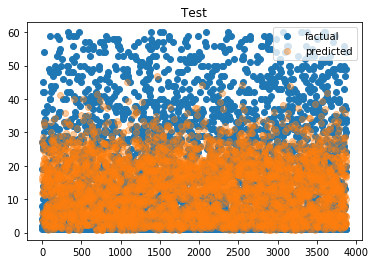

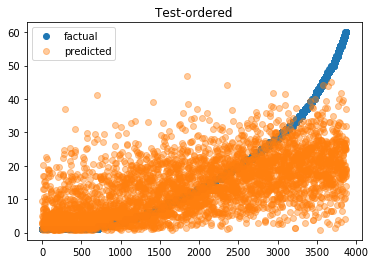

In [40]:
# plt.plot(y_train.data.cpu().numpy(),'o',label='factual')
# plt.plot(y_hat_train.data.cpu().numpy(),'o',label='predicted',alpha=0.4)
# plt.legend()
# plt.title('Train')
# plt.show()

# idx_ord = np.argsort(y_train.data.cpu().numpy())
# plt.plot(y_train.data.cpu().numpy()[idx_ord],'o',label='factual')
# plt.plot(y_hat_train.data.cpu().numpy()[idx_ord],'o',label='predicted',alpha=0.05)
# plt.legend()
# plt.title('Train-ordered')
# plt.show()

plt.plot(y_test.data.cpu().numpy(),'o',label='factual')
plt.plot(y_hat_test.data.cpu().numpy(),'o',label='predicted',alpha=0.4)
plt.legend()
plt.title('Test')
plt.show()

idx_ord = np.argsort(y_test.data.cpu().numpy())
plt.plot(y_test.data.cpu().numpy()[idx_ord],'o',label='factual')
plt.plot(y_hat_test.data.cpu().numpy()[idx_ord],'o',label='predicted',alpha=0.4)
plt.legend()
plt.title('Test-ordered')
plt.show()

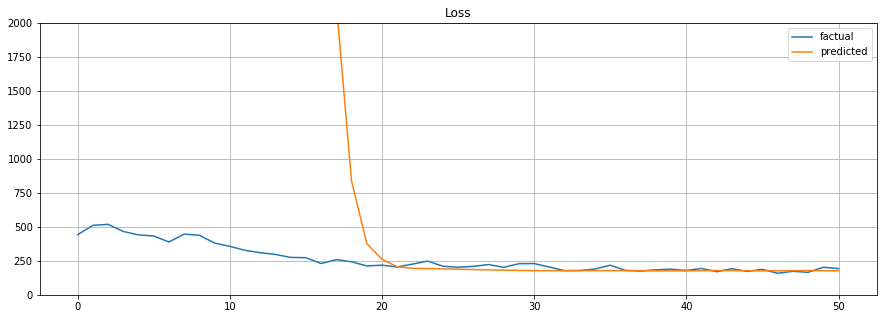

MSE(train/test): 192/176 -- RMSE(train/test): 13/13


In [41]:
plt.figure(figsize=(15,5))
plt.plot(loss_train_list,label='factual')
plt.plot(loss_test_list,label='predicted')
plt.legend()
plt.title('Loss')
plt.ylim((0,2000))
plt.grid(True)
plt.show()

print('MSE(train/test): %s/%s'%(int(loss_train_list[-1]),int(loss_test_list[-1])), '--',  'RMSE(train/test): %s/%s'%(int(np.sqrt(loss_train_list[-1])),int(np.sqrt(loss_test_list[-1]))) )